# Домашнее задание № 8

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
from IPython.display import Image
from IPython.core.display import HTML 
import matplotlib.pyplot as plt
%matplotlib inline

## Задание 1 (4 балла) 

Обучите 8 моделей для задачи классификации текста (датасет - lenta_40k ). А именно:  
1) модель с 1 GRU слоем;   
2) модель с 1 LSTM слоем    
3) модель с 1 GRU и 1 LSTM слоем  
4) модель с 1 BIGRU и 2 LSTM слоями  
5) модель с 5 GRU слоями и 3 LSTM слоями  
6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались   
7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM  



Параметр units и размер эмбединга можете задать любой. Оцените качество каждой модели и определите победителя.

In [ ]:
data = pd.read_csv('lenta_40k.csv.zip')

In [ ]:
def preprocess(text):
    tokens = text.lower().split()
    tokens = [token.strip(punctuation) for token in tokens]
    return tokens

In [ ]:
from tensorflow.keras import backend as K
def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
vocab = Counter()

for text in data.text:
    vocab.update(preprocess(text))

In [ ]:
len(vocab)

354611

In [ ]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [ ]:
len(filtered_vocab)

24091

In [ ]:
word2id = {'PAD':0, 'UNK':1}

for word in filtered_vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
X = []

for text in data.text:
    tokens = preprocess(text)
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
MAX_LEN = max(len(x) for x in X)
MEAN_LEN = np.median([len(x) for x in X])

In [ ]:
MAX_LEN, MEAN_LEN

(1748, 170.0)

In [ ]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN)

In [ ]:
id2label = {i:label for i, label in enumerate(set(data.topic.values))}
label2id = {l:i for i, l in id2label.items()}

In [ ]:
y = tf.keras.utils.to_categorical([label2id[label] for label in data.topic.values])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05, stratify=y)

#### 1) модель с 1 GRU слоем

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru = tf.keras.layers.GRU(128, return_sequences=False)(embeddings)

dense = tf.keras.layers.Dense(64, activation='relu')(gru)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

2023-02-18 13:55:58.476836: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-02-18 13:55:58.476902: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=10)

Epoch 1/10
43/43 [==============================] - 592s 14s/step - loss: 2.5913 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3308 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
43/43 [==============================] - 574s 13s/step - loss: 2.2551 - f1: 2.7709e-04 - rec@prec: 0.0000e+00 - val_loss: 2.1757 - val_f1: 0.0090 - val_rec@prec: 0.0000e+00
Epoch 3/10
43/43 [==============================] - 579s 13s/step - loss: 2.0795 - f1: 0.0197 - rec@prec: 0.0000e+00 - val_loss: 2.0284 - val_f1: 0.0044 - val_rec@prec: 0.0014
Epoch 4/10
43/43 [==============================] - 565s 13s/step - loss: 1.8056 - f1: 0.0445 - rec@prec: 0.0027 - val_loss: 1.8039 - val_f1: 0.0998 - val_rec@prec: 0.0289
Epoch 5/10
43/43 [==============================] - 568s 13s/step - loss: 1.6841 - f1: 0.2119 - rec@prec: 0.0851 - val_loss: 1.9504 - val_f1: 0.1927 - val_rec@prec: 0.0221
Epoch 6/10
43/43 [==============================] - 566s 13s/step - loss: 1.4976 - f1: 0.4033 - rec@prec: 0.

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


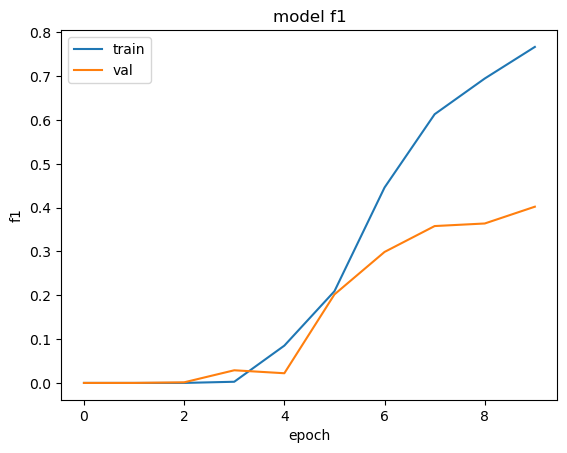

In [ ]:
print(model.history.history.keys())
# summarize history for accuracy
plt.plot(model.history.history['rec@prec'])
plt.plot(model.history.history['val_rec@prec'])
plt.title('model f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### 2) модель с 1 LSTM слоем

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=50)(inputs, )

lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=False))(embeddings)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm)

model_lstm = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model_lstm.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=1000,
          epochs=10)

Epoch 1/10
43/43 [==============================] - 1317s 30s/step - loss: 2.4578 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3180 - val_f1: 0.0000e+00 - val_rec@prec: 9.0171e-04
Epoch 2/10
43/43 [==============================] - 1282s 30s/step - loss: 2.2978 - f1: 0.0000e+00 - rec@prec: 2.3732e-05 - val_loss: 2.2530 - val_f1: 0.0000e+00 - val_rec@prec: 0.0095
Epoch 3/10
43/43 [==============================] - 1254s 29s/step - loss: 2.0184 - f1: 0.0951 - rec@prec: 0.0636 - val_loss: 2.0054 - val_f1: 0.3003 - val_rec@prec: 0.1307
Epoch 4/10
43/43 [==============================] - 1250s 29s/step - loss: 1.5438 - f1: 0.4032 - rec@prec: 0.2248 - val_loss: 1.4774 - val_f1: 0.4644 - val_rec@prec: 0.2710
Epoch 5/10
43/43 [==============================] - 1255s 29s/step - loss: 1.3381 - f1: 0.5532 - rec@prec: 0.3667 - val_loss: 1.4350 - val_f1: 0.4695 - val_rec@prec: 0.2687
Epoch 6/10
43/43 [==============================] - 1243s 29s/step - loss: 1.1674 - f1: 0.6338 - rec@prec: 

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


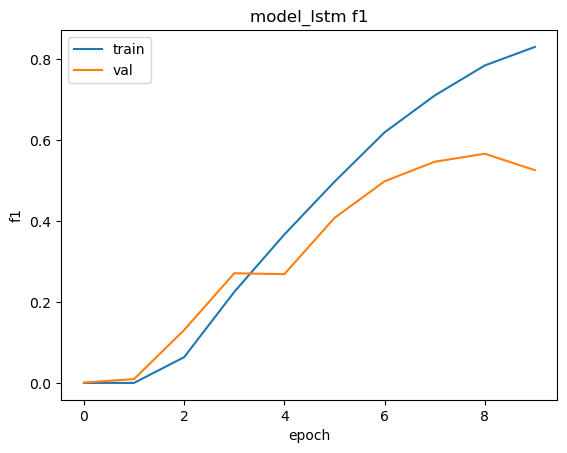

In [ ]:
print(model_lstm.history.history.keys())
# summarize history for accuracy
plt.plot(model_lstm.history.history['rec@prec'])
plt.plot(model_lstm.history.history['val_rec@prec'])
plt.title('model_lstm f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### 3) модель с 1 GRU и 1 LSTM слоем

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=50)(inputs, )

gru = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
lstm = tf.keras.layers.LSTM(128, return_sequences=False)(gru)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model_gl = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_gl.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

2023-02-19 06:25:52.826925: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64::/opt/conda/lib
2023-02-19 06:25:52.826999: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)


In [ ]:
model_gl.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=500,
          epochs=10)                                       

Epoch 1/10
85/85 [==============================] - 1901s 22s/step - loss: 2.3251 - f1: 0.0012 - rec@prec: 0.0000e+00 - val_loss: 2.0210 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
85/85 [==============================] - 1937s 23s/step - loss: 1.7868 - f1: 0.1089 - rec@prec: 0.0648 - val_loss: 1.7091 - val_f1: 0.1485 - val_rec@prec: 0.0938
Epoch 3/10
85/85 [==============================] - 1809s 21s/step - loss: 1.6129 - f1: 0.2216 - rec@prec: 0.1134 - val_loss: 1.6996 - val_f1: 0.3081 - val_rec@prec: 0.0956
Epoch 4/10
85/85 [==============================] - 1782s 21s/step - loss: 1.3895 - f1: 0.4567 - rec@prec: 0.2394 - val_loss: 1.4397 - val_f1: 0.5317 - val_rec@prec: 0.2831
Epoch 5/10
85/85 [==============================] - 1869s 22s/step - loss: 1.1528 - f1: 0.6124 - rec@prec: 0.4627 - val_loss: 1.3700 - val_f1: 0.5751 - val_rec@prec: 0.3886
Epoch 6/10
85/85 [==============================] - 1914s 23s/step - loss: 1.0108 - f1: 0.6658 - rec@prec: 0.5707 - val_los

dict_keys(['loss', 'f1', 'rec@prec', 'val_loss', 'val_f1', 'val_rec@prec'])


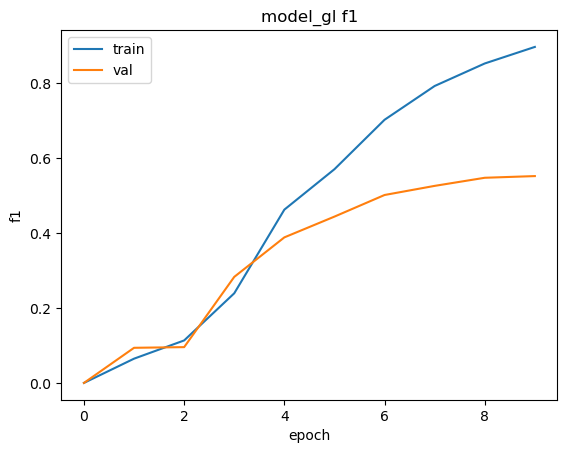

In [ ]:
print(model_gl.history.history.keys())
# summarize history for accuracy
plt.plot(model_gl.history.history['rec@prec'])
plt.plot(model_gl.history.history['val_rec@prec'])
plt.title('model_gl f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### 4) модель с 1 BIGRU и 2 LSTM слоями

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
lstm1 = tf.keras.layers.LSTM(32, return_sequences=True)(bigru)
lstm2 = tf.keras.layers.LSTM(32, return_sequences=False)(lstm1)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model_bl = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_bl.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model_bl.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=500,
          epochs=10)

Epoch 1/10


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


85/85 [==============================] - 77s 792ms/step - loss: 2.4564 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3252 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
85/85 [==============================] - 65s 768ms/step - loss: 2.3235 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3215 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/10
85/85 [==============================] - 65s 768ms/step - loss: 2.3227 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3201 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/10
85/85 [==============================] - 65s 760ms/step - loss: 2.3205 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3003 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/10
85/85 [==============================] - 65s 764ms/step - loss: 2.0163 - f1: 0.0289 - rec@prec: 0.0000e+00 - val_loss: 1.8930 - val_f1: 0.1648 - val_rec@prec: 0.0027
Epoch 6/10
85/85 [==============================] - 64s 758ms/step - loss: 1.6

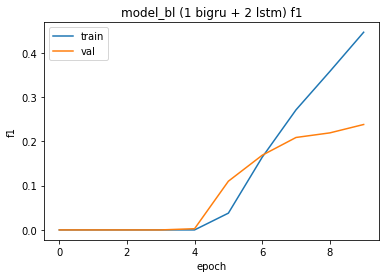

In [ ]:
plt.plot(model_bl.history.history['rec@prec'])
plt.plot(model_bl.history.history['val_rec@prec'])
plt.title('model_bl (1 bigru + 2 lstm) f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### 5) модель с 5 GRU слоями и 3 LSTM слоями

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

gru1 = tf.keras.layers.GRU(128, return_sequences=True)(embeddings)
gru2 = tf.keras.layers.GRU(32, return_sequences=True)(gru1)
gru3 = tf.keras.layers.GRU(32, return_sequences=True)(gru2)
gru4 = tf.keras.layers.GRU(32, return_sequences=True)(gru3)
gru5 = tf.keras.layers.GRU(32, return_sequences=True)(gru4)

lstm1 = tf.keras.layers.LSTM(32, return_sequences=True)(gru5)
lstm2 = tf.keras.layers.LSTM(32, return_sequences=True)(lstm1)
lstm3 = tf.keras.layers.LSTM(32, return_sequences=False)(lstm2)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm3)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model_gl2 = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_gl2.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model_gl2.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=500,
          epochs=10)

Epoch 1/10


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


85/85 [==============================] - 92s 904ms/step - loss: 2.4523 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3250 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
85/85 [==============================] - 71s 840ms/step - loss: 2.3241 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3209 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/10
85/85 [==============================] - 70s 827ms/step - loss: 2.3228 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3218 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/10
85/85 [==============================] - 70s 824ms/step - loss: 2.3227 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3206 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/10
85/85 [==============================] - 70s 819ms/step - loss: 2.3226 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3204 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 6/10
85/85 [==============================] - 70s 825ms/step

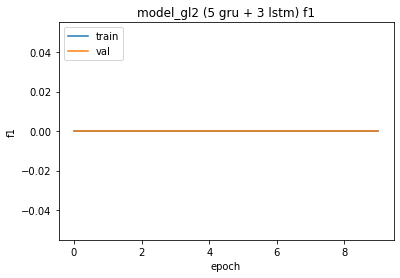

In [ ]:
plt.plot(model_gl2.history.history['rec@prec'])
plt.plot(model_gl2.history.history['val_rec@prec'])
plt.title('model_gl2 (5 gru + 3 lstm) f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### 6) модель 1 BIGRU и 1 BILSTM слоями, причем так чтобы модели для forward и backward прохода отличались

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

bigru_bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False),
                                             backward_layer=tf.keras.layers.LSTM(32, return_sequences=False, go_backwards=True))(embeddings)

dense = tf.keras.layers.Dense(64, activation='relu')(bigru_bilstm)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model_bb = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_bb.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])

In [ ]:
model_bb.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=500,
          epochs=10)

Epoch 1/10


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


85/85 [==============================] - 49s 429ms/step - loss: 2.4093 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.0710 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
85/85 [==============================] - 41s 481ms/step - loss: 1.9072 - f1: 0.0827 - rec@prec: 0.0338 - val_loss: 1.7277 - val_f1: 0.1577 - val_rec@prec: 0.1010
Epoch 3/10
85/85 [==============================] - 33s 384ms/step - loss: 1.5716 - f1: 0.2791 - rec@prec: 0.1451 - val_loss: 1.5956 - val_f1: 0.3455 - val_rec@prec: 0.1479
Epoch 4/10
85/85 [==============================] - 32s 371ms/step - loss: 1.3195 - f1: 0.5189 - rec@prec: 0.3198 - val_loss: 1.4244 - val_f1: 0.5232 - val_rec@prec: 0.3264
Epoch 5/10
85/85 [==============================] - 31s 364ms/step - loss: 1.0791 - f1: 0.6339 - rec@prec: 0.5160 - val_loss: 1.3740 - val_f1: 0.5603 - val_rec@prec: 0.3909
Epoch 6/10
85/85 [==============================] - 31s 361ms/step - loss: 0.9176 - f1: 0.6901 - rec@prec: 0.6194 - val_loss: 1.38

KeyboardInterrupt: ignored

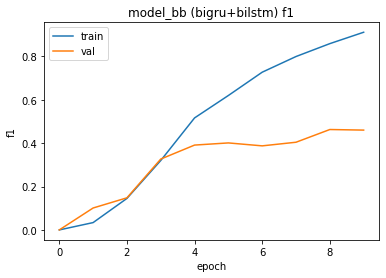

In [ ]:
plt.plot(model_bb.history.history['rec@prec'])
plt.plot(model_bb.history.history['val_rec@prec'])
plt.title('model_bb (bigru+bilstm) f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

#### 7) модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=30)(inputs, )

lstm1 = tf.keras.layers.LSTM(32, return_sequences=True)(embeddings)
gru1 = tf.keras.layers.GRU(128, return_sequences=True)(lstm1)
bilstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(gru1)
bigru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, return_sequences=True))(bilstm)
gru2 = tf.keras.layers.GRU(32, return_sequences=True)(bigru)
lstm2 = tf.keras.layers.LSTM(32, return_sequences=False)(gru2)

dense = tf.keras.layers.Dense(64, activation='relu')(lstm2)
outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(dense)

model_all = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_all.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=[f1, tf.keras.metrics.RecallAtPrecision(0.8, name='rec@prec')])


In [ ]:
model_all.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          batch_size=500,
          epochs=10)

Epoch 1/10


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


85/85 [==============================] - 107s 1s/step - loss: 2.4295 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3244 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 2/10
85/85 [==============================] - 84s 987ms/step - loss: 2.3236 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3198 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 3/10
85/85 [==============================] - 84s 989ms/step - loss: 2.3226 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3193 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 4/10
85/85 [==============================] - 82s 971ms/step - loss: 2.3218 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3193 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 5/10
85/85 [==============================] - 81s 954ms/step - loss: 2.3219 - f1: 0.0000e+00 - rec@prec: 0.0000e+00 - val_loss: 2.3189 - val_f1: 0.0000e+00 - val_rec@prec: 0.0000e+00
Epoch 6/10
85/85 [==============================] - 81s 958ms/step -

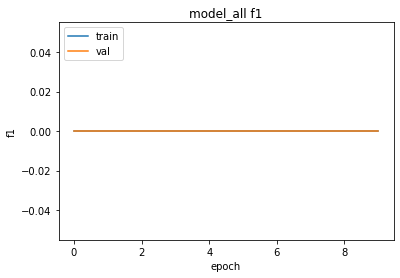

In [ ]:
plt.plot(model_all.history.history['rec@prec'])
plt.plot(model_all.history.history['val_rec@prec'])
plt.title('model_all f1')
plt.ylabel('f1')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

##### Summary

На последней эпохе метрика f1_val выше всего у модели с 1 lstm слоем, на 2 месте модель с 1 gru и 1 lstm слоем. Модель с 5 gru и 3 lstm и модель, где последовательно идут слои: LSTM, GRU, BILSTM, BIGRU, GRU, LSTM, почему-то совсем необучились. Возможно, это из-за того, что я сильно сокращала batch-size, кол-во эпох и юнитов. Но без этого у меня очень долго все работало или не запускалось вообще

## Задание 2 (6 баллов)


На данных википедии (wikiann) обучите 2 модели:  
1) модель в которой будут использованы предобученные эмбединги слов и несколько BILSTM слоев. 
1) модель в которой будут использованы предобученные эмбединги слов и несколько BIGRU слоев. 

Сравните качество по метрикам. Также придумайте несколько сложных примеров и проверьте, какие сущности определяет каждая из моделей.

In [ ]:
from datasets import load_dataset
dataset = load_dataset("wikiann", 'ru')

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/ru/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
vocab = Counter()

for sent in dataset['train']['tokens']:
    vocab.update([x.lower() for x in sent])

In [ ]:
len(vocab)

36015

In [ ]:
word2id = {'PAD':0, 'UNK':1}

for word in vocab:
    word2id[word] = len(word2id)

In [ ]:
id2word = {i:word for word, i in word2id.items()}

In [ ]:
X = []

for sent in dataset['train']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X.append(ids)

In [ ]:
X_test = []

for sent in dataset['test']['tokens']:
    tokens = [w.lower() for w in sent]
    ids = [word2id.get(token, 1) for token in tokens]
    X_test.append(ids)

In [ ]:
MAX_LEN = max(len(x) for x in X)

# паддинг
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_LEN, padding='post')
X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=MAX_LEN, padding='post')

In [ ]:
id2labels = {0:'O', 1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6:'I-LOC', 7:'PAD'}
label2id = {v:k for k,v in id2labels.items()} 

In [ ]:
y = tf.keras.preprocessing.sequence.pad_sequences(dataset['train']['ner_tags'], value=7,
                                                  maxlen=MAX_LEN,  padding='post')
y_test = tf.keras.preprocessing.sequence.pad_sequences(dataset['test']['ner_tags'], value=7,
                                                       maxlen=MAX_LEN,  padding='post')

In [ ]:
X.shape, X_test.shape

((20000, 54), (10000, 54))

In [ ]:
y.shape, y_test.shape

((20000, 54), (10000, 54))

1) предобученные эмбединги слов и несколько BILSTM слоев

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

lstm_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(embeddings)
lstm_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(lstm_1)
lstm_3 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(lstm_2)
lstm_4 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True))(lstm_3)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(lstm_4)

model1 = tf.keras.Model(inputs=inputs, outputs=outputs)
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model1.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
          epochs=5)

Epoch 1/5
157/157 [==============================] - 24s 129ms/step - loss: 0.4239 - accuracy: 0.9157 - val_loss: 0.1889 - val_accuracy: 0.9416
Epoch 2/5
157/157 [==============================] - 7s 44ms/step - loss: 0.1507 - accuracy: 0.9523 - val_loss: 0.1251 - val_accuracy: 0.9594
Epoch 3/5
157/157 [==============================] - 5s 33ms/step - loss: 0.0954 - accuracy: 0.9706 - val_loss: 0.0876 - val_accuracy: 0.9733
Epoch 4/5
157/157 [==============================] - 3s 22ms/step - loss: 0.0562 - accuracy: 0.9843 - val_loss: 0.0702 - val_accuracy: 0.9782
Epoch 5/5
157/157 [==============================] - 3s 22ms/step - loss: 0.0333 - accuracy: 0.9920 - val_loss: 0.0633 - val_accuracy: 0.9796


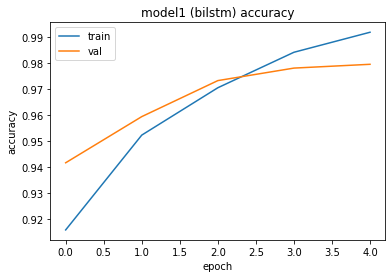

In [ ]:
plt.plot(model1.history.history['accuracy'])
plt.plot(model1.history.history['val_accuracy'])
plt.title('model1 (bilstm) accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
pred = model1.predict(X_test).argmax(2)

313/313 [==============================] - 3s 6ms/step


In [ ]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.94      0.91      0.93     40480
       B-PER       0.73      0.80      0.77      3542
       I-PER       0.87      0.87      0.87      7544
       B-ORG       0.69      0.59      0.64      4074
       I-ORG       0.79      0.75      0.77      8008
       B-LOC       0.54      0.75      0.63      4560
       I-LOC       0.78      0.66      0.71      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.79      0.79      0.79    540000
weighted avg       0.98      0.98      0.98    540000



2) предобученные эмбединги слов и несколько BIGRU слоев

In [ ]:
inputs = tf.keras.layers.Input(shape=(MAX_LEN,))
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=100)(inputs)

bigru1 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(embeddings)
bigru2 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru1)
bigru3 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru2)
bigru4 = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=True))(bigru3)

outputs = tf.keras.layers.Dense(len(label2id), activation='softmax')(bigru4)

model2 = tf.keras.Model(inputs=inputs, outputs=outputs)
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [ ]:
model2.fit(X, y, 
          validation_data=(X_test, y_test),
          batch_size=128,
          epochs=5)

Epoch 1/5
157/157 [==============================] - 44s 142ms/step - loss: 0.2195 - accuracy: 0.9352 - val_loss: 0.1060 - val_accuracy: 0.9655
Epoch 2/5
157/157 [==============================] - 11s 69ms/step - loss: 0.0621 - accuracy: 0.9797 - val_loss: 0.0486 - val_accuracy: 0.9840
Epoch 3/5
157/157 [==============================] - 9s 58ms/step - loss: 0.0183 - accuracy: 0.9944 - val_loss: 0.0537 - val_accuracy: 0.9836
Epoch 4/5
157/157 [==============================] - 8s 54ms/step - loss: 0.0086 - accuracy: 0.9975 - val_loss: 0.0571 - val_accuracy: 0.9845
Epoch 5/5
157/157 [==============================] - 8s 54ms/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 0.0677 - val_accuracy: 0.9828


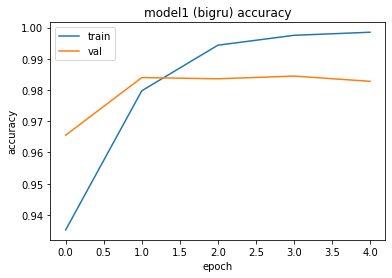

In [ ]:
plt.plot(model2.history.history['accuracy'])
plt.plot(model2.history.history['val_accuracy'])
plt.title('model1 (bigru) accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
pred = model2.predict(X_test).argmax(2)

313/313 [==============================] - 7s 10ms/step


In [ ]:
print(classification_report(y_test.reshape(-1), pred.reshape(-1), labels=list(id2labels.keys()),
                                                                     target_names=list(id2labels.values()),
                                                                     zero_division=0))

              precision    recall  f1-score   support

           O       0.96      0.91      0.94     40480
       B-PER       0.89      0.85      0.87      3542
       I-PER       0.93      0.90      0.91      7544
       B-ORG       0.50      0.81      0.62      4074
       I-ORG       0.70      0.85      0.77      8008
       B-LOC       0.84      0.67      0.75      4560
       I-LOC       0.90      0.68      0.77      3060
         PAD       1.00      1.00      1.00    468732

    accuracy                           0.98    540000
   macro avg       0.84      0.83      0.83    540000
weighted avg       0.99      0.98      0.98    540000



##### Summary

Кажется, что по метрикам для отдельных именных сущностей вторая модель чуть лучше первой, хотя общий accuracy у них на одном уровне

In [ ]:
import re

def tokenize(text, word2id):
    # токенизирует и переводит в индексы
    tokens = re.findall('\w+|[^\w\s]+', text)
    ids = [word2id.get(token.lower(), 1) for token in tokens]
    return tokens, ids

def pred2tags(pred, id2label, length):
    # декодирует индексы в части речи
    # length нужно чтобы откидывать паддинги или некорректные предсказания
    pred = pred.argmax(2)[0, :length]
    labels = [id2label[l] for l in pred]
    return labels

def label_seq(text, word2id, id2label, max_len, model):
    tokens, ids = tokenize(text, word2id)
    pred = model.predict(tf.keras.preprocessing.sequence.pad_sequences([ids], 
                                                                       maxlen=max_len, 
                                                                       padding='post'))
    labels = pred2tags(pred, id2label, len(ids))
    
    return list(zip(tokens, labels))

In [ ]:
label_seq('Я поступил в ВШЭ в Питер', word2id, id2labels, MAX_LEN, model1)

1/1 [==============================] - 0s 78ms/step


[('Я', 'O'),
 ('поступил', 'O'),
 ('в', 'O'),
 ('ВШЭ', 'O'),
 ('в', 'O'),
 ('Питер', 'I-PER')]

In [ ]:
label_seq('Я поступил в ВШЭ в Питер', word2id, id2labels, MAX_LEN, model2)

1/1 [==============================] - 0s 47ms/step


[('Я', 'O'),
 ('поступил', 'O'),
 ('в', 'O'),
 ('ВШЭ', 'B-ORG'),
 ('в', 'I-ORG'),
 ('Питер', 'I-ORG')]

In [ ]:
label_seq('15 февраля Дима Билан выступил в Лужниках с юбилейным концертом', word2id, id2labels, MAX_LEN, model1)

1/1 [==============================] - 0s 24ms/step


[('15', 'B-ORG'),
 ('февраля', 'I-ORG'),
 ('Дима', 'B-ORG'),
 ('Билан', 'B-ORG'),
 ('выступил', 'O'),
 ('в', 'O'),
 ('Лужниках', 'B-ORG'),
 ('с', 'O'),
 ('юбилейным', 'I-ORG'),
 ('концертом', 'PAD')]

In [ ]:
label_seq('15 февраля Дима Билан выступил в Лужниках с юбилейным концертом', word2id, id2labels, MAX_LEN, model2)

1/1 [==============================] - 0s 45ms/step


[('15', 'B-PER'),
 ('февраля', 'I-PER'),
 ('Дима', 'I-PER'),
 ('Билан', 'I-PER'),
 ('выступил', 'O'),
 ('в', 'O'),
 ('Лужниках', 'B-PER'),
 ('с', 'I-PER'),
 ('юбилейным', 'I-PER'),
 ('концертом', 'I-ORG')]

15 февраля и Диму Билана первая модель считает организацией, вторая - человеком (тут она, наверное, права больше первой). В целом, почему-то первая модель почти всему присвоила тег ORG, вторая - PER


In [ ]:
label_seq('Настя, Юля, Никита, Сергей Петрович, Любим, Коля, Николай', word2id, id2labels, MAX_LEN, model1)

1/1 [==============================] - 0s 38ms/step


[('Настя', 'B-PER'),
 (',', 'O'),
 ('Юля', 'B-PER'),
 (',', 'O'),
 ('Никита', 'B-PER'),
 (',', 'O'),
 ('Сергей', 'I-PER'),
 ('Петрович', 'I-PER'),
 (',', 'I-PER'),
 ('Любим', 'I-PER'),
 (',', 'O'),
 ('Коля', 'I-PER'),
 (',', 'I-PER'),
 ('Николай', 'I-PER')]

In [ ]:
label_seq('Настя, Юля, Никита, Сергей Петрович, Любим, Коля, Николай', word2id, id2labels, MAX_LEN, model2)

1/1 [==============================] - 0s 27ms/step


[('Настя', 'B-PER'),
 (',', 'I-PER'),
 ('Юля', 'I-PER'),
 (',', 'O'),
 ('Никита', 'B-PER'),
 (',', 'I-PER'),
 ('Сергей', 'B-PER'),
 ('Петрович', 'I-PER'),
 (',', 'O'),
 ('Любим', 'B-PER'),
 (',', 'O'),
 ('Коля', 'B-PER'),
 (',', 'I-PER'),
 ('Николай', 'I-PER')]

С именами обе модели справились хорошо, но в некоторых местах почему-то приняли запятую за человека